In [9]:
#Shishir Khanal
#July 8, 2025
#Vector AutoRegression Moving Average
import numpy as np
import pandas as pd
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
from pmdarima import auto_arima

df = pd.read_csv('M2SLMoneyStock.csv',index_col=0,parse_dates=True)
df.index.freq='MS'

sp = pd.read_csv('PCEPersonalSpending.csv',index_col=0,parse_dates=True)
sp.index.freq='MS'

/home/shishir/anaconda3/envs/tsa_course/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


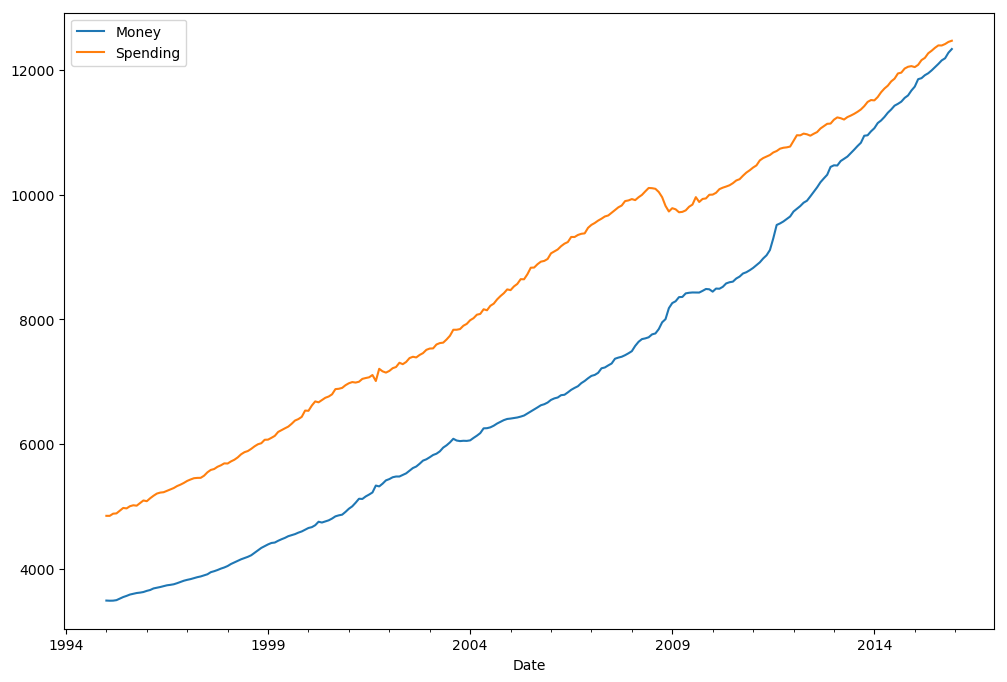

In [10]:
df = df.join(sp)
df = df.dropna()
df.plot(figsize=(12,8))

In [11]:
#Test for stationarity
def adf_test(series, title=''):
    print(f'Augmented D-F Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') #dropna to handle differenced data

    labels = ['ADF test statistic', 'p-value','# lags used', '# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})'] = val

    print(out.to_string()) #convert fom float64 to string

    if result[1] <= 0.05:
        print("Strong evidence against null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject null hypothesis")
        print("Data has a unit root and is non-stationary")

In [12]:
adf_test(df['Money'])

Augmented D-F Test: 
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject null hypothesis
Data has a unit root and is non-stationary


In [13]:
adf_test(df['Spending'])

Augmented D-F Test: 
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject null hypothesis
Data has a unit root and is non-stationary


In [14]:
auto_arima(df['Money'],maxiter=1000)

ARIMA(callback=None, disp=0, maxiter=1000, method=None, order=(1, 2, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)

In [15]:
auto_arima(df['Spending'],maxiter=1000)

ARIMA(callback=None, disp=0, maxiter=1000, method=None, order=(1, 1, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)

In [17]:
df_transformed = df.diff().diff()
df_transformed = df_transformed.dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [18]:
len(df_transformed)

250

In [19]:
nobs=12
train = df_transformed[:-nobs] #start = beginnning of DF --Go to--> -12 from end
test = df_transformed[-nobs:] #start = -12 from end --Go to--> end of DF

In [20]:
#VARMA
model = VARMAX(train, order=(1,2), trend='c') #constant linear trend
results = model.fit(maxiter=1000, disp=False)
results.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.571
,+ intercept,AIC,4607.143
Date:,"Wed, 09 Jul 2025",BIC,4666.171
Time:,00:00:30,HQIC,4630.932
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (Q):,"69.30, 28.01",Jarque-Bera (JB):,"541.12, 121.21"
Prob(Q):,"0.00, 0.92",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.57, 2.88",Skew:,"1.32, -0.33"


In [22]:
df_forecast = results.forecast(12)
df_forecast

,Money,Spending
2015-01-01,-11.907846,37.496606
2015-02-01,-11.036214,-4.119087
2015-03-01,0.741355,-0.205823
2015-04-01,-1.258600,-0.109470
2015-05-01,0.770062,0.276505
2015-06-01,-0.213927,0.140770
2015-07-01,0.377631,0.233830
2015-08-01,0.047431,0.183943
2015-09-01,0.236311,0.212877
2015-10-01,0.129151,0.196536


In [24]:
#Opposite of Differencing

#Add most recent first difference from training side of the original dataset to the forecast cumsum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()

#Build forecast values from first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money1d'].cumsum()

In [25]:
#Add most recent first difference from training side of the original dataset to the forecast cumsum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()

#Build forecast values from first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1d'].cumsum()

In [26]:
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-11.907846,37.496606,66.692154,11736.792154,48.096606,12110.096606
2015-02-01,-11.036214,-4.119087,55.655941,11792.448095,43.977519,12154.074126
2015-03-01,0.741355,-0.205823,56.397296,11848.845391,43.771696,12197.845822
2015-04-01,-1.258600,-0.109470,55.138696,11903.984086,43.662226,12241.508048
2015-05-01,0.770062,0.276505,55.908757,11959.892844,43.938731,12285.446779
2015-06-01,-0.213927,0.140770,55.694830,12015.587674,44.079501,12329.526281
2015-07-01,0.377631,0.233830,56.072461,12071.660134,44.313331,12373.839611
2015-08-01,0.047431,0.183943,56.119891,12127.780026,44.497273,12418.336885
2015-09-01,0.236311,0.212877,56.356203,12184.136228,44.710150,12463.047035
2015-10-01,0.129151,0.196536,56.485354,12240.621583,44.906686,12507.953721


In [27]:
pd.concat([df.iloc[-12:],df_forecast[['MoneyForecast','SpendingForecast']]], axis=1)

,Money,Spending,MoneyForecast,SpendingForecast
Date,,,,
2015-01-01,11733.2,12046.0,11736.792154,12110.096606
2015-02-01,11852.4,12082.4,11792.448095,12154.074126
2015-03-01,11868.8,12158.3,11848.845391,12197.845822
2015-04-01,11916.1,12193.8,11903.984086,12241.508048
2015-05-01,11947.6,12268.1,11959.892844,12285.446779
2015-06-01,11993.1,12308.3,12015.587674,12329.526281
2015-07-01,12045.3,12355.4,12071.660134,12373.839611
2015-08-01,12096.8,12394.0,12127.780026,12418.336885
2015-09-01,12153.8,12392.8,12184.136228,12463.047035


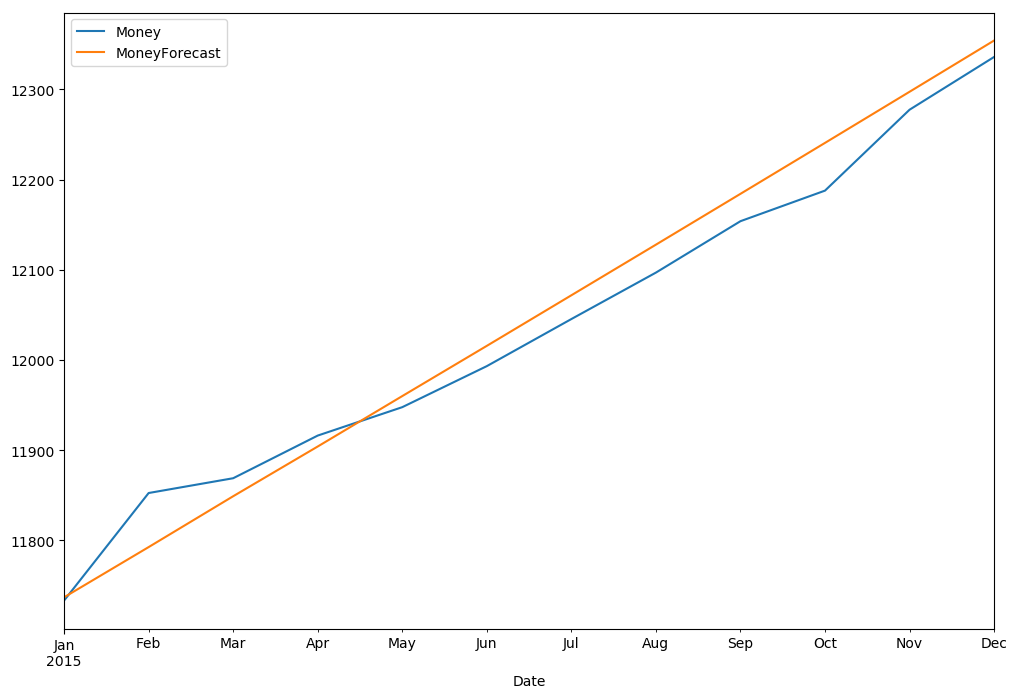

In [28]:
df['Money'][-nobs:].plot(figsize=(12,8),legend=True).autoscale(axis='x',tight=True)
df_forecast['MoneyForecast'].plot(legend=True);

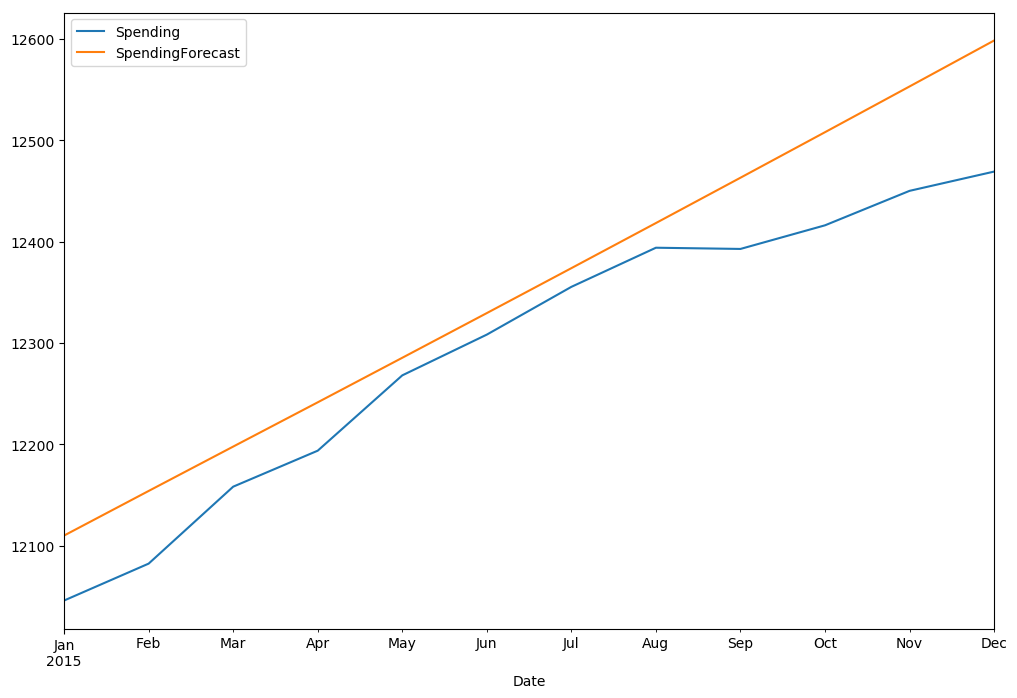

In [29]:
df['Spending'][-nobs:].plot(figsize=(12,8),legend=True).autoscale(axis='x',tight=True)
df_forecast['SpendingForecast'].plot(legend=True);

In [31]:
RMSE1 = rmse(df['Money'][-nobs:],df_forecast['MoneyForecast'])
print(f'Money VAR(5) RMSE: {RMSE1:.3f}')

Money VAR(5) RMSE: 30.156


In [32]:
RMSE2 = rmse(df['Spending'][-nobs:],df_forecast['SpendingForecast'])
print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')

Spending VAR(5) RMSE: 67.981


In [33]:
################################
#Compare with ARMA Model
################################

In [35]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults

In [36]:
model = ARMA(train['Money'],order=(1,2))
results = model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.69925D+00    |proj g|=  1.99317D-02

At iterate    5    f=  4.69846D+00    |proj g|=  1.57986D-02

At iterate   10    f=  4.69775D+00    |proj g|=  6.28457D-03

At iterate   15    f=  4.69637D+00    |proj g|=  2.01679D-03

At iterate   20    f=  4.69627D+00    |proj g|=  5.58931D-04

At iterate   25    f=  4.69626D+00    |proj g|=  3.22498D-04

At iterate   30    f=  4.69626D+00    |proj g|=  3.69482D-05

At iterate   35    f=  4.69626D+00    |proj g|=  2.55795D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Money   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1117.710
Method:                       css-mle   S.D. of innovations             26.214
Date:                Wed, 09 Jul 2025   AIC                           2245.421
Time:                        00:26:53   BIC                           2262.782
Sample:                    03-01-1995   HQIC                          2252.418
                         - 12-01-2014                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1814      0.029      6.302      0.000       0.125       0.238
ar.L1.Money    -0.3569      0.293     -1.218      0.225      -0.931       0.218
ma.L1.Money    -0.4087      0.260     -1.573      0.117      -0.918       0.101
ma.L2.Money    -0.5912      0.260     -2.278      0.024      -1.100      -0.083
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.8022           +0.0000j            2.8022            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.6913           +0.0000j            1.6913            0.5000
-----------------------------------------------------------------------------
"""

In [40]:
start = len(train)
end = len(train) + len(test) - 1
z1 = results.predict(start=start, end=end).rename('Money')
z1 = pd.DataFrame(z1)
z1

,Money
2015-01-01,-14.499036
2015-02-01,-10.947090
2015-03-01,4.152748
2015-04-01,-1.235831
2015-05-01,0.687155
2015-06-01,0.000912
2015-07-01,0.245807
2015-08-01,0.158413
2015-09-01,0.189601
2015-10-01,0.178471


In [42]:
#Invert differencing

#Add most recent first difference from training side of the original dataset to the forecast cumsum
z1['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + z1['Money'].cumsum()

#Build forecast values from first difference set
z1['MoneyForecast'] = df['Money'].iloc[-nobs-1] + z1['Money1d'].cumsum()
z1

,Money,Money1d,MoneyForecast
2015-01-01,-14.499036,64.100964,11734.200964
2015-02-01,-10.947090,53.153874,11787.354838
2015-03-01,4.152748,57.306622,11844.661459
2015-04-01,-1.235831,56.070791,11900.732250
2015-05-01,0.687155,56.757946,11957.490196
2015-06-01,0.000912,56.758858,12014.249054
2015-07-01,0.245807,57.004665,12071.253720
2015-08-01,0.158413,57.163078,12128.416798
2015-09-01,0.189601,57.352679,12185.769477
2015-10-01,0.178471,57.531150,12243.300626


In [43]:
RMSE3 = rmse(df['Money'][-nobs:],z1['MoneyForecast'])

print(f'Money VARMA(1,2) RMSE: {RMSE1:.3f}')
print(f'Money  ARMA(1,2) RMSE: {RMSE3:.3f}')

Money VARMA(1,2) RMSE: 30.156
Money  ARMA(1,2) RMSE: 32.236


In [44]:
model = ARMA(train['Spending'],order=(1,2))
results = model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.96828D+00    |proj g|=  1.73364D-03

At iterate    5    f=  4.96818D+00    |proj g|=  3.03935D-04

At iterate   10    f=  4.96812D+00    |proj g|=  7.14095D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     25      1     0     0   1.776D-07   4.968D+00
  F =   4.9681154693862730     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 Cauchy                time 0.000E+00 seconds.
 Subspace minimization

 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               Spending   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1182.411
Method:                       css-mle   S.D. of innovations             34.661
Date:                Wed, 09 Jul 2025   AIC                           2374.823
Time:                        00:33:04   BIC                           2392.184
Sample:                    03-01-1995   HQIC                          2381.820
                         - 12-01-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0856      0.245      0.350      0.727      -0.394       0.565
ar.L1.Spending    -0.3403      0.511     -0.666      0.506      -1.342       0.661
ma.L1.Spending    -0.6451      0.521     -1.237      0.217      -1.667       0.377
ma.L2.Spending    -0.2139      0.485     -0.441      0.660      -1.165       0.737
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.9387           +0.0000j            2.9387            0.5000
MA.1            1.1281           +0.0000j            1.1281            0.0000
MA.2           -4.1437           +0.0000j            4.1437            0.5000
-----------------------------------------------------------------------------
"""

In [45]:
z2 = results.predict(start=start, end=end).rename('Spending')
z2 = pd.DataFrame(z2)
z2

,Spending
2015-01-01,33.555774
2015-02-01,-3.338218
2015-03-01,1.250723
2015-04-01,-0.310851
2015-05-01,0.220539
2015-06-01,0.039712
2015-07-01,0.101245
2015-08-01,0.080306
2015-09-01,0.087432
2015-10-01,0.085007


In [46]:
#Invert differencing

#Add most recent first difference from training side of the original dataset to the forecast cumsum
z2['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + z2['Spending'].cumsum()

#Build forecast values from first difference set
z2['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + z2['Spending1d'].cumsum()
z2

,Spending,Spending1d,SpendingForecast
2015-01-01,33.555774,44.155774,12106.155774
2015-02-01,-3.338218,40.817556,12146.973331
2015-03-01,1.250723,42.068280,12189.041610
2015-04-01,-0.310851,41.757429,12230.799040
2015-05-01,0.220539,41.977968,12272.777008
2015-06-01,0.039712,42.017680,12314.794687
2015-07-01,0.101245,42.118925,12356.913612
2015-08-01,0.080306,42.199231,12399.112843
2015-09-01,0.087432,42.286663,12441.399506
2015-10-01,0.085007,42.371669,12483.771175


In [47]:
RMSE4 = rmse(df['Spending'][-nobs:],z2['SpendingForecast'])

print(f'Money VARMA(1,2) RMSE: {RMSE2:.3f}')
print(f'Money  ARMA(1,2) RMSE: {RMSE4:.3f}')

Money VARMA(1,2) RMSE: 67.981
Money  ARMA(1,2) RMSE: 52.334
